# Bass guitar simulation using siconos - Profiling

In this notebook, "computeOneStep" call is rewritten in details in order to 
profile each simulation step.



## Jupyter notebooks reminder

A notebook is a sequence of "cells" that can be executed.


Each cell can handle either python code or markdown for comments.

* Edit a cell : Enter
* Execute a cell: Shift + Enter
* Run all cells : kernel menu (top of the page) --> Run all
* Delete cell : DD
* Add cell : Ctrl-mb
* Shortcuts reminder : Ctrl-m h
* List all magic commands : %lsmagic

More :  https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html#references

Warning : cells can be executed in any order but results and variables are persistent (until a call to %reset or kernel->restart)


## Debug/test mode only

Execute the cell below only during debug/profile phase

In [1]:
# Load profiler    
%load_ext line_profiler
# Reload automatically all python modules before each cell exec
%load_ext autoreload
%autoreload 2

## Load siconos and guitar packages

In [17]:
# standard python packages
import sys
import time
import os
# guitar package
from guitar import StringDS, Fret, Guitar
from model_tools import build_frets_from_file, save_simu_to_hdf5, load_model, load_data

# Guitar pre-defined setups
import parameters

# siconos package
import siconos.kernel as sk

# python packages for vectors/matrices operations
import numpy as np
import scipy.io
# python plots
import matplotlib.pyplot as plt
%matplotlib inline

## Create a 'guitar' model

Build dynamical systems, interactions, simulation ...
   
### Select case :

comment/uncomment lines below to choose the case to be run.

In [3]:
# One string, one contact
# case = 'one_contact'
# 'standard' bass : one string, 20 frets
case = 'bass'
# Fretless bass
#case = 'fretless'

# Activate (or not) contacts
with_contacts = True

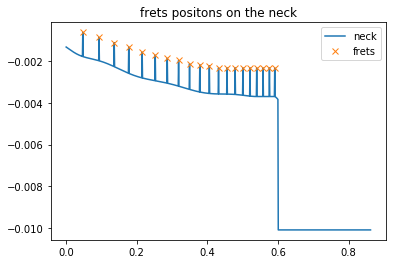

In [4]:
if case == 'bass':
        
    run_case = parameters.bass_guitar

elif case == 'fretless':
    
    run_case = parameters.fretless_bass_guitar

elif case == 'one_contact':

    run_case = parameters.one_contact

# set or overload parameters value
matlab_input = run_case['matlab_input']
number_of_modes = run_case['nb_modes']
max_coords = run_case['max_coords']
filt_frets = run_case['filt_frets']
G_string = {
    'length': run_case['length']
    # diameter = equivalent diameter (A5)
    #'diameter': 1.14e-3,
    #'density': 6.69e-3,
    #'B': 3.5e-5,
    #'tension': 191.6,
    }

output_name = run_case['output_name']

restit = 0.9

output_name += str(restit)

initial_time = 0.
final_time = 0.01
visu = True # plot frets/neck 

fs = 15680. #1003520
output_freq = 64


# -- The dynamical system --
string = StringDS(number_of_modes, geometry_and_material=G_string,
                  max_coords=max_coords,
                  matlab_input=matlab_input)

# -- Contacts/interactions --
current_path = './'
if with_contacts:
    frets_file = os.path.join(current_path, matlab_input) + '_h.mat'
    interactions = build_frets_from_file(string, restit, frets_file, filt_frets, visu)

    frets = list(interactions.keys())
    nb_frets = len(frets)
else:

    interactions = {None : string}
    frets = []
    nb_frets = len(frets)

In [5]:
guitar_model = Guitar(interactions, [initial_time, final_time],
                      fs, output_freq, interactions_output=2) # 2 to save y and lambda
# Save initial state
guitar_model.time[0] = initial_time
guitar_model.save_ds_state_modal(0, string)

buff = guitar_model.data_interactions
for i in range(nb_frets):
    buff[frets[i]][0][0] = frets[i].y(0) 
    buff[frets[i]][1][0] = frets[i].lambda_(1) 

# Get simulation object
simu = guitar_model.simulation
osns = guitar_model.osnspb
osi = guitar_model.default_integrator
print('Ready to start simulation for frequency {0}.'.format(fs))
print('Save output every {0} time steps.'.format(output_freq))
msg = 'Read data from files :\n'
msg += '- neck profile:' + frets_file
msg += '\n- eigenfrequencies: ' + matlab_input + '_frequs.mat\n'
msg += '- damping: ' + matlab_input + '_amortissements.mat\n'
print(msg)


Ready to start simulation for frequency 15680.0.
Save output every 64 time steps.
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: bass_guitar/pb2_frequs.mat
- damping: bass_guitar/pb2_amortissements.mat



## Run simulation

In [6]:
def one_step(k, pos, start_time):
    simu.initialize()
    
    if k % 100000 == 0:
        print('step = ', k, '---- time = ',
              simu.nextTime(),
              '------- duration = ', time.clock() - start_time, '-------------')
    # - advanceToEvent() - TimeStepping.cpp
    simu.resetLambdas()
    # -- newtonSolve -- TimeStepping.cpp
    # --- simu.initializeNewtonLoop() --- TimeStepping.cpp
    # skip # tkp1 = simu.getTkp1()
    # skip #   guitar_model.default_integrator.computeInitialNewtonState()
    # skip #   guitar_model.default_integrator.computeResidu()
    # skip # simu.updateInteractions()
    simu.updateContactsFromChangeLog()
    # skip # simu.updateWorldFromDS()
    sindex = sk.size_graph(simu.indexSet(osns.indexSetLevel()))
    if sindex>0:
        guitar_model.default_integrator.updateOutput(simu.nextTime())
        guitar_model.default_integrator.updateInput(simu.nextTime())
    # skip # guitar_string.updatePlugins(tkp1)
    # skip # guitar_model.default_integrator.computeResidu()
    # --- --- end of initializeNewtonLoop
    # skip # simu.prepareNewtonIteration()
    simu.computeFreeState()
    # --- ComputeOneStepNSProblem --- Simulation.cpp
    #if simu.nonSmoothDynamicalSystem().topology().hasChanged():
    osns.setHasBeenUpdated(False)
    # ---- osnsob.compute() ---- LCP.cpp
    cont = osns.preCompute(simu.nextTime())
    
    
    #if sindex > 0:
    #    print("I1 size/ iteration number", sindex, k)
    #res = False
    #if sindex != 0:    
        #up2date = osns.hasBeenUpdated()
        #if not up2date:
    #    osns.updateInteractionBlocks()
    #    osns.updateOperators()
    #    res = True
    #    osns.computeq(time)
    #osns.displayBlocks(simu.indexSet(1))
    # osns.computeq(simu.nextTime())
    info = 0
    if cont: #res:
        if osns.getSizeOutput() != 0:
            info = osns.numericsCompute()
            osns.postCompute()
    # ---- ---- end of compute
    # --- --- end of computeOneStepNSProblem
    #simu.computeOneStepNSProblem(sk.SICONOS_OSNSP_TS_VELOCITY)
    simu.DefaultCheckSolverOutput(info)
    # --- update --- Simulation.hpp
    simu.updateInput()
    simu.updateState()
    simu.updateOutput()
    # --- --- end of update
    simu.saveYandLambdaInOldVariables()
    # -- -- end of newtonSolve
    # - - end of advanceToEvent
    # -- save data every output_freq time step --
    if k % guitar_model.output_freq == 0:
        # current time
        guitar_model.time[pos] = simu.nextTime()
        # modal positions
        guitar_model.save_ds_state_modal(pos, string)
        
        # interactions
        if guitar_model.save_interactions:
            buff = guitar_model.data_interactions
            for i in range(nb_frets):
                buff[frets[i]][0][pos] = frets[i].y(0) 
                buff[frets[i]][1][pos] = frets[i].lambda_(1) 
                #buff[frets[i]][2][pos = frets[i].y(1) 

        pos += 1
    k += 1
    simu.nextStep()
    return k, pos

def run():
    k = 1
    pos = 1
    #while k < 500:
    #while simu.nextTime() < 1.:
    start_time = time.clock() 
    while simu.hasNextEvent():
        k, pos = one_step(k, pos, start_time)
        print(k,pos)
    



In [7]:
%lprun -f  one_step run()

2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 2
66 2
67 2
68 2
69 2
70 2
71 2
72 2
73 2
74 2
75 2
76 2
77 2
78 2
79 2
80 2
81 2
82 2
83 2
84 2
85 2
86 2
87 2
88 2
89 2
90 2
91 2
92 2
93 2
94 2
95 2
96 2
97 2
98 2
99 2
100 2
101 2
102 2
103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 3
130 3
131 3
132 3
133 3
134 3
135 3
136 3
137 3
138 3
139 3
140 3
141 3
142 3
143 3
144 3
145 3
146 3
147 3
148 3
149 3
150 3
151 3
152 3
153 3
154 3
155 3
156 3
157 3


#  Post-treatment

## Save data to hdf file

1. Convert data from modal to nodal values
2. Write results into hdf5 file

In [12]:
guitar_model.convert_modal_output(string)
save_simu_to_hdf5(guitar_model, string, matlab_data=matlab_input, filename='./tmp.h5', filt_frets=filt_frets, restit=restit)